In [1]:
using Plots

**Universidade Federal de Alagoas**<br>
**Instituto de Computação**<br>
**Engenharia de Computação**<br>
**Disciplina**: Modelagem do Sistema Cardiovascular Humano<br>
**Professor**: Thiago D. Cordeiro<br>
**Alunos**: Hugo Tallys Martins Oliveira e Valério Nogueira Rodrigues Júnior<br>

# Implementação da função Elastância

Implemente a função elastância descrita por Lim *et al*. [1] e compare a curva desta
função com aquela descrita por Simaan *et al*. [2]. Sabendo que o parâmetro elastância
máxima é utilizado para representar a condição de contratilidade do ventrículo, e que
quanto maior o seu valor maior a força de contratilidade do mesmo, utilize dois valores
para este parâmetro de modo a representar duas condições para o ventrículo.

## Lim *et al*.
$$  
e_v(t) = 
    \begin{cases}
        sin(\frac{\pi(t - t_{sh, i})}{2T_{r,i}})^2 &\quad t_{sh, i} \leq t < (t_{sh,i} + T_{r, i}) \\
        cos(\frac{\pi(t - t_{sh, i} - T_{r, i})}{2(T_{sys,i} - T_{r,i})})^2 &\quad t_{sh, i} (t_{sh,i} + T_{r, i}) \leq t < (t_{sh, i} + T_{sys, i}) \\
        0 &\quad 0 \leq t < (t_{sh,i}) \text{ or } (t_{sh, i} + T_{sys, i}) \leq t < T \\
    \end{cases}
$$

Definindo o modelo:

In [2]:
T = 1.0
k_sys = 0.1
t_sh = 0

function eᵥ(t, T_sys0 = 0.54, k_r = 0.83)
    
    T_sys = T_sys0 - (k_sys / T)
    T_r = k_r * T_sys
    
    t %= T
    if ((t_sh + T_sys) <= t < T) || (0.0 <= t < t_sh)    
        return 0.0
    elseif t_sh <= t < (t_sh + T_r)
        num = π * (t - t_sh)
        den = 2T_r
        return sin(num / den)^2
    elseif (t_sh + T_r) <=  t < (t_sh + T_sys)
        num = π * (t - t_sh - T_r)
        den = 2.0 * (T_sys - T_r)
        return cos(num / den)^2
    end
end;

Definindo o intervalo de tempo:

In [3]:
t = 0:0.0001:2T

0.0:0.0001:2.0

Plotando a cruva descrita por _Lim. et al._. Os parâmetros escolhidos são:

* $T_{sys0} = 0.54$ ( ... )
* $k_r = 0.83$ ( ... )

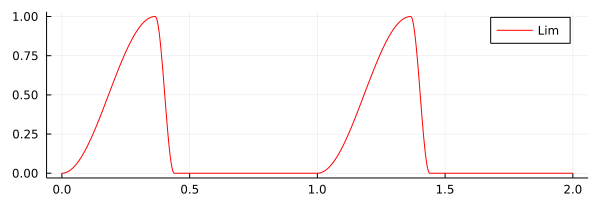

In [4]:
lim = map(eᵥ, t)
plot(t, lim, label="Lim", size = (600, 200), color="red")

## Simaan *et al*.

$$ E(t) = (E_{max} - E_{min})E_n(t_n) + E_{min} $$

onde:

$$
E_n(t) = 1.55 * \left[ \frac{\left(\frac{t_n}{0.7}\right)^{1.9}}{1 + \left(\frac{t_n}{0.7}\right)^{1.9}} \right] * \left[ \frac{1}{1 + \left(\frac{t_n}{1.17}\right)^{21.9}} \right]
$$

Definindo o modelo:

In [5]:
Eₘₐₓ = 2.0
Eₘᵢₙ = 0.06
HR = 60
tc = 60 / HR
Tₘₐₓ = 0.2 + 0.15tc

function Eₙ(tₙ)
    n₁ = (tₙ / 0.7) ^ 1.9
    n₂ = (tₙ / 1.17) ^ 21.9
    return 1.55 * (n₁ / (1 + n₁)) * (1 / (1 + n₂))
end;

function E(t) 
    return (Eₘₐₓ - Eₘᵢₙ) * Eₙ(t/Tₘₐₓ) + Eₘᵢₙ
end;

Plotando a curva descrita por _Simaan_:

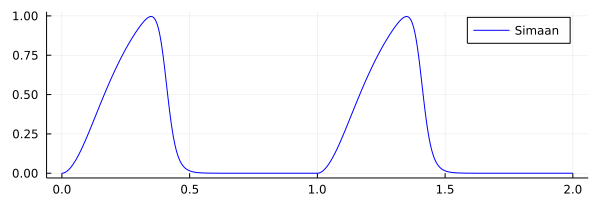

In [6]:
simaan = map(Eₙ, t .% T ./ Tₘₐₓ)
plot(t, simaan, label="Simaan", size = (600, 200), color="blue")

## Comparando os dois modelos

Para comparar os dois modelos, vamos tentar aproximar ao máximo a curva descrita por _Lim_ daquela descrita por _Simaan_. Para isso, variar os parâmetros $T_{sys0}, k_r$ realizando uma busca completa de modo a minimizar a seguinte função:

$$min_{(T_{sys0}, k_r)}\{(S - L(T_{sys0}, k_r))^2\}$$

In [7]:
function compute_error(a, b)
    return sum((eᵥ.(t, a, b) .- simaan) .^ 2)
end

x = 0.0:0.01:1.0
p = Iterators.product(x, x)

grid_values = Array{Float64}(undef, length(p))

i = 1
for t in p
    grid_values[i] = compute_error(t[1], t[2])
    i += 1
end

i = 1
min_i = argmin(grid_values)
min_t = nothing
for t in p
    if i == min_i
        min_t = t
    end
    i += 1
end

println(min_t)

(0.58, 0.73)


Econtramos um valor mínimo do erro no ponto onde:

$$ (T_{sys0}, k_r) = (0.58, 0.73) $$

Visualizando o erro em função dos parâmetros:

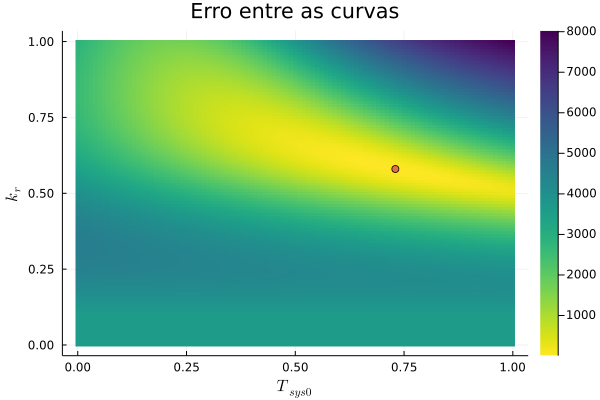

In [8]:
n = Int64(√length(p))
heat = reshape(grid_values, (n, n))
heatmap(x, x, heat, c=cgrad(:viridis, rev=true), title="Erro entre as curvas", xlabel="\$T_{sys0}\$", ylabel="\$k_r\$")
scatter!([min_t[2]],[min_t[1]], legend=false)

Resultado final:

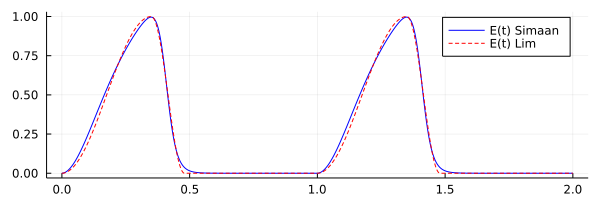

In [9]:
plot(t, simaan, label = "E(t) Simaan", color="blue")
lim = eᵥ.(t, min_t[1], min_t[2])
plot!(t, lim, line = :dash, label = "E(t) Lim", size = (600, 200), color="red")

# Referências

[1] Lim E, Dokos S, Cloherty SL, Salamonsen RF, Mason DG, Reizes JA, Lovell NH.**Parameter-optimized model of cardiovascular–rotary blood pump interactions**. IEEE Transactions on Biomedical Engineering. 2009 Sep 18;57(2):254-66.

[2] Simaan MA, Ferreira A, Chen S, Antaki JF, Galati DG. **A dynamical state space representation and performance analysis of a feedback-controlled rotary left ventricular assist device**. IEEE Transactions on Control Systems Technology. 2008 Dec 22;17(1):15-28.